In [79]:
%pip install ipywidgets
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Mục Tiêu :Dự đoán mức độ thảm họa (nhỏ - lớn – siêu thảm họa)

Cài đặt thư viện và Import

In [80]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display


Load và Việt hóa dữ liệu 

In [81]:
# ============================================================
# CELL 2: LOAD DỮ LIỆU & VIỆT HÓA TOÀN DIỆN 
# ============================================================
import pandas as pd

# 1. LOAD FILE
# ------------------------------------------------------------
file_path = r"C:\Users\ASUS\OneDrive\文档\GitHub\predict_the_severity_of_the_disaster\Du-Doan-Tham-Hoa-Toan-Cau\global_disaster_response_2018_2024.csv"

try:
    df = pd.read_csv(file_path)
    print("Đã đọc file thành công!")
except FileNotFoundError:
    print(" LỖI: Không tìm thấy file. Hãy kiểm tra lại đường dẫn!")
    df = pd.DataFrame()

# 2. CHUẨN BỊ TỪ ĐIỂN DỊCH ()
# ------------------------------------------------------------
vn_disaster_map = {
    # --- Nhóm Đã dịch trước đó ---
    'Flood': 'Lũ lụt', 
    'Storm': 'Bão', 
    'Earthquake': 'Động đất',
    'Epidemic': 'Dịch bệnh', 
    'Landslide': 'Sạt lở đất', 
    'Drought': 'Hạn hán',
    'Wildfire': 'Cháy rừng',
    'Tsunami': 'Sóng thần',
    'Insect infestation': 'Côn trùng phá hoại',
    'Mass movement (dry)': 'Sạt lở (khô)', 
    'Volcanic activity': 'Núi lửa', 
    'Extreme temperature': 'Nhiệt độ cực đoan',
    'Hurricane': 'Bão lớn (Hurricane)',
    'Extreme Heat': 'Nắng nóng cực đoan',
    'Storm Surge': 'Nước dâng do bão',
    'Volcanic Eruption': 'Phun trào núi lửa',
    'Tornado': 'Lốc xoáy'
}


if 'disaster_type' in df.columns:
    df['disaster_type'] = df['disaster_type'].replace(vn_disaster_map)

# Bước 3b: Đổi tên cột
df = df.rename(columns={
    "country": "Quốc_gia",
    "disaster_type": "Loại_thảm_họa",
    "latitude": "Vĩ_độ",
    "longitude": "Kinh_độ",
    "date": "Ngày",
    "severity_index": "Chỉ_số_nghiêm_trọng",
    "casualties": "Số_người_thương_vong",
    "economic_loss_usd": "Thiệt_hại_kinh_tế_USD",
    "response_time_hours": "Thời_gian_phản_ứng_giờ",
    "aid_amount_usd": "Viện_trợ_USD",
    "response_efficiency_score": "Hiệu_quả_ứng_phó",
    "recovery_days": "Số_ngày_phục_hồi"
})

# 4. XỬ LÝ NGÀY THÁNG
# ------------------------------------------------------------
df['Ngày_dt'] = pd.to_datetime(df['Ngày'], dayfirst=True, errors='coerce')
df['Tháng'] = df['Ngày_dt'].dt.month

# 5. KIỂM TRA LẠI
# ------------------------------------------------------------
print("\n Kiểm tra danh sách thiên tai sau khi dịch:")
print(df['Loại_thảm_họa'].value_counts())

Đã đọc file thành công!

 Kiểm tra danh sách thiên tai sau khi dịch:
Loại_thảm_họa
Sạt lở đất             5130
Động đất               5068
Lũ lụt                 5039
Bão lớn (Hurricane)    5002
Nắng nóng cực đoan     5001
Nước dâng do bão       4988
Phun trào núi lửa      4983
Cháy rừng              4954
Lốc xoáy               4939
Hạn hán                4896
Name: count, dtype: int64


In [82]:
print(df.columns)


Index(['Ngày', 'Quốc_gia', 'Loại_thảm_họa', 'Chỉ_số_nghiêm_trọng',
       'Số_người_thương_vong', 'Thiệt_hại_kinh_tế_USD',
       'Thời_gian_phản_ứng_giờ', 'Viện_trợ_USD', 'Hiệu_quả_ứng_phó',
       'Số_ngày_phục_hồi', 'Vĩ_độ', 'Kinh_độ', 'Ngày_dt', 'Tháng'],
      dtype='object')


In [83]:
# =========================
# TỌA ĐỘ TRUNG BÌNH THEO QUỐC GIA
# =========================
country_coords = (
    df.groupby("Quốc_gia")[["Vĩ_độ", "Kinh_độ"]]
      .mean()
      .reset_index()
)

country_coord_dict = {
    row["Quốc_gia"]: (row["Vĩ_độ"], row["Kinh_độ"])
    for _, row in country_coords.iterrows()
}


In [84]:
def classify_disaster(severity):
    if severity < 3:
        return 0        # Nhỏ
    elif severity < 6:
        return 1        # Lớn
    else:
        return 2        # Siêu thảm họa



Chuyển bài toán từ Hồi quy (dự đoán điểm số cụ thể) sang Phân loại (dự đoán mức độ).

< 3: Mức 0 (Nhỏ)

3 - 6: Mức 1 (Lớn)

>= 6: Mức 2 (Siêu thảm họa)

Ý nghĩa: Việc chia nhóm này giúp bài toán dễ quản lý hơn và phù hợp với logic cảnh báo thiên tai 

In [85]:
df["Mức_độ_thảm_họa"] = df["Chỉ_số_nghiêm_trọng"].apply(classify_disaster)
df["Mức_độ_thảm_họa"].value_counts()


Mức_độ_thảm_họa
1    26854
2    15391
0     7755
Name: count, dtype: int64

In [86]:
df_ml = df.copy()

X = df_ml.drop(columns=["Ngày", "Mức_độ_thảm_họa", "Chỉ_số_nghiêm_trọng"])
y = df_ml["Mức_độ_thảm_họa"]

X (Đầu vào): Loại bỏ cột Ngày , bỏ Mức_độ_thảm_họa và Chỉ_số_nghiêm_trọng (vì đây là đáp án).

y (Đầu ra): Chính là cột Mức_độ_thảm_họa.

Lưu ý: Bạn đã tạo cột Tháng ở Cell 2 nhưng chưa đưa vào X. Nếu đưa Tháng vào X, mô hình có thể học được tính "mùa vụ" ví dụ: tháng 7 hay có bão

In [87]:

numerical_features = [
    "Số_người_thương_vong",
    "Thiệt_hại_kinh_tế_USD",
    "Thời_gian_phản_ứng_giờ",
    "Viện_trợ_USD",
    "Hiệu_quả_ứng_phó",
    "Số_ngày_phục_hồi",
    "Vĩ_độ",
    "Kinh_độ",
    "Tháng"
]



Trực quan hóa dữ liệu (EDA)

In [88]:
# Thống kê số lượng theo loại thảm họa
disaster_counts = df['Loại_thảm_họa'].value_counts()

print("Các loại thảm họa xảy ra nhiều nhất:")
print(disaster_counts)


Các loại thảm họa xảy ra nhiều nhất:
Loại_thảm_họa
Sạt lở đất             5130
Động đất               5068
Lũ lụt                 5039
Bão lớn (Hurricane)    5002
Nắng nóng cực đoan     5001
Nước dâng do bão       4988
Phun trào núi lửa      4983
Cháy rừng              4954
Lốc xoáy               4939
Hạn hán                4896
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35276\3266980179.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


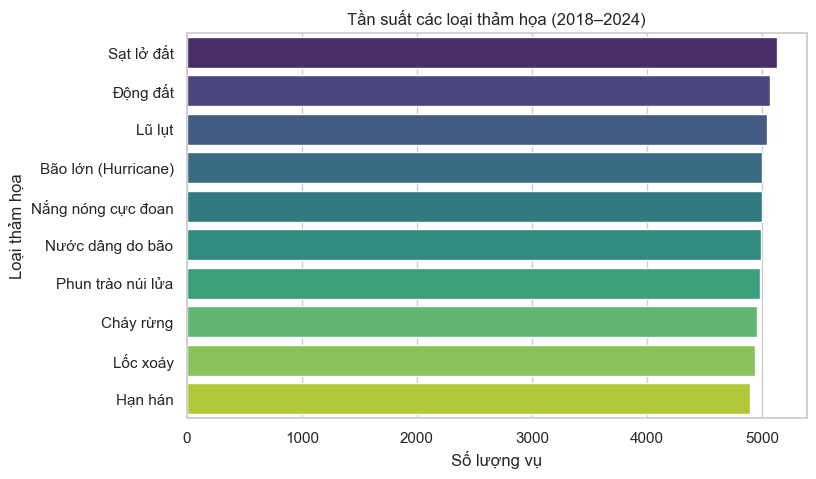

In [89]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=disaster_counts.values,
    y=disaster_counts.index,
    palette="viridis"
)
plt.title("Tần suất các loại thảm họa (2018–2024)")
plt.xlabel("Số lượng vụ")
plt.ylabel("Loại thảm họa")
plt.show()


In [90]:
top_disaster_by_country = (
    df.groupby(['Quốc_gia', 'Loại_thảm_họa'])
      .size()
      .reset_index(name='count')
      .sort_values(['Quốc_gia', 'count'], ascending=[True, False])
)

top_disaster_by_country.head(30)


,Quốc_gia,Loại_thảm_họa,count
8,Australia,Sạt lở đất,281
5,Australia,Nước dâng do bão,269
6,Australia,Nắng nóng cực đoan,269
9,Australia,Động đất,267
3,Australia,Lũ lụt,260
1,Australia,Cháy rừng,259
4,Australia,Lốc xoáy,252
0,Australia,Bão lớn (Hurricane),240
2,Australia,Hạn hán,240
7,Australia,Phun trào núi lửa,226


In [91]:
top1_each_country = (
    df.groupby(['Quốc_gia', 'Loại_thảm_họa'])
      .size()
      .reset_index(name='Số_vụ')
      .sort_values(['Quốc_gia', 'Số_vụ'], ascending=[True, False])
      .groupby('Quốc_gia')
      .head(1)
)
top1_each_country.sort_values('Số_vụ', ascending=False).head(10)



,Quốc_gia,Loại_thảm_họa,Số_vụ
57,China,Phun trào núi lửa,287
48,Chile,Sạt lở đất,286
180,Turkey,Bão lớn (Hurricane),284
171,Spain,Cháy rừng,283
75,Germany,Nước dâng do bão,282
8,Australia,Sạt lở đất,281
23,Brazil,Lũ lụt,281
19,Bangladesh,Động đất,279
83,Greece,Lũ lụt,275
169,South Africa,Động đất,274


In [92]:
severity_by_type = (
    df.groupby(['Loại_thảm_họa', 'Mức_độ_thảm_họa'])
      .size()
      .unstack(fill_value=0)
)

severity_by_type


Mức_độ_thảm_họa,0,1,2
Loại_thảm_họa,,,
Bão lớn (Hurricane),763,2713,1526
Cháy rừng,734,2679,1541
Hạn hán,794,2698,1404
Lũ lụt,826,2705,1508
Lốc xoáy,733,2597,1609
Nước dâng do bão,756,2700,1532
Nắng nóng cực đoan,799,2646,1556
Phun trào núi lửa,740,2657,1586
Sạt lở đất,806,2718,1606


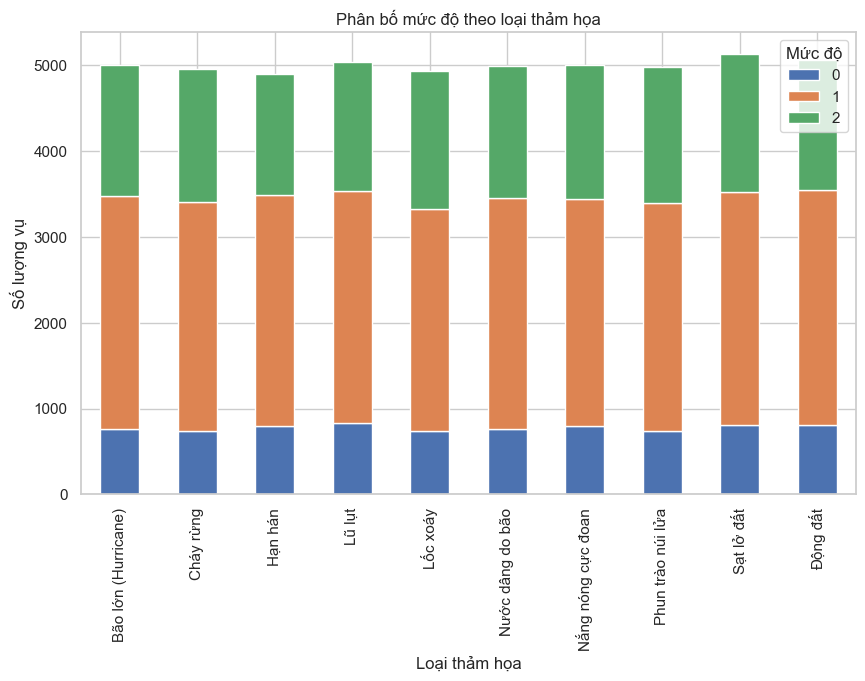

In [93]:
severity_by_type.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6)
)
plt.title("Phân bố mức độ theo loại thảm họa")
plt.xlabel("Loại thảm họa")
plt.ylabel("Số lượng vụ")
plt.legend(title="Mức độ")
plt.show()


sns.barplot: Xem loại thảm họa nào phổ biến nhất (Sạt lở đất, Động đất...).

groupby theo Quốc gia: Tìm ra nước nào hay bị thiên tai gì nhất (ví dụ: Úc hay bị cháy rừng).

stacked bar chart: Xem phân bố mức độ nghiêm trọng trong từng loại thảm họa.

In [94]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Categorical features:", categorical_features)


Categorical features: ['Quốc_gia', 'Loại_thảm_họa']


In [95]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [97]:
rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("RANDOM FOREST")
print(classification_report(y_test, y_pred_rf))


RANDOM FOREST
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1551
           1       0.88      0.92      0.90      5371
           2       0.90      0.88      0.89      3078

    accuracy                           0.89     10000
   macro avg       0.90      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [98]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=5,
    scoring="f1_weighted"
)

print("F1-weighted CV scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


F1-weighted CV scores: [0.89876133 0.89035642 0.89636631 0.90093053 0.89684564]
Mean CV F1: 0.8966520476790546


In [99]:
# Lấy model Random Forest đã train
rf = rf_model.named_steps["model"]

# Lấy tên feature sau preprocessing
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

# Feature importance
importances = pd.Series(
    rf.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

importances.head(10)


num__Số_ngày_phục_hồi          0.511511
num__Thời_gian_phản_ứng_giờ    0.112371
num__Viện_trợ_USD              0.092534
num__Thiệt_hại_kinh_tế_USD     0.074329
num__Số_người_thương_vong      0.071288
num__Hiệu_quả_ứng_phó          0.070771
num__Kinh_độ                   0.014500
num__Vĩ_độ                     0.014349
num__Tháng                     0.008235
cat__Loại_thảm_họa_Động đất    0.001305
dtype: float64

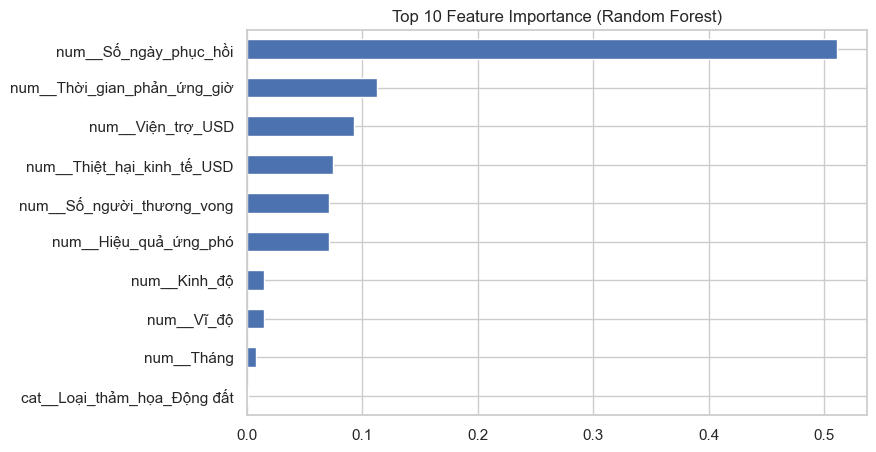

In [100]:
importances.head(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


In [101]:
lgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        random_state=42
    ))
])

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LIGHTGBM")
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621618
[LightGBM] [Info] Start training from score -1.178224
LIGHTGBM
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1551
           1       0.89      0.91      0.90      5371
           2       0.89      0.88      0.88      3078

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [112]:
lgb_cv = cross_val_score(lgb_model, X, y, cv=5, scoring="f1_weighted")
print(f"LightGBM - Mean F1: {lgb_cv.mean():.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621618
[LightGBM] [Info] Start training from score -1.178224


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621618
[LightGBM] [Info] Start training from score -1.178224


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621618
[LightGBM] [Info] Start training from score -1.178224


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621618
[LightGBM] [Info] Start training from score -1.178224


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 39
[LightGBM] [Info] Start training from score -1.863685
[LightGBM] [Info] Start training from score -0.621571
[LightGBM] [Info] Start training from score -1.178305
LightGBM - Mean F1: 0.8963


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [102]:
xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        random_state=42,
        eval_metric="mlogloss"
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBOOST")
print(classification_report(y_test, y_pred_xgb))


XGBOOST
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1551
           1       0.89      0.91      0.90      5371
           2       0.89      0.88      0.88      3078

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [113]:
xgb_cv = cross_val_score(xgb_model, X, y, cv=5, scoring="f1_weighted")
print(f"XGBoost - Mean F1: {xgb_cv.mean():.4f}")

XGBoost - Mean F1: 0.8953


In [114]:
mlp_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        max_iter=500,
        random_state=42
    ))
])

mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("NEURAL NETWORK")
print(classification_report(y_test, y_pred_mlp))


NEURAL NETWORK
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1551
           1       0.87      0.86      0.87      5371
           2       0.85      0.85      0.85      3078

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.86      0.86      0.86     10000



In [115]:
mlp_cv = cross_val_score(mlp_model, X, y, cv=5, scoring="f1_weighted")
print(f"Neural Network - Mean F1: {mlp_cv.mean():.4f}")

Neural Network - Mean F1: 0.8602


In [116]:
results = pd.DataFrame({
    "Model": ["Random Forest", "LightGBM", "XGBoost", "Neural Network"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lgb),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_mlp)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_lgb, average="weighted"),
        f1_score(y_test, y_pred_xgb, average="weighted"),
        f1_score(y_test, y_pred_mlp, average="weighted")
    ]
})

results


,Model,Accuracy,F1-score
0,Random Forest,0.8929,0.892615
1,LightGBM,0.8924,0.892323
2,XGBoost,0.8909,0.890787
3,Neural Network,0.8589,0.858977


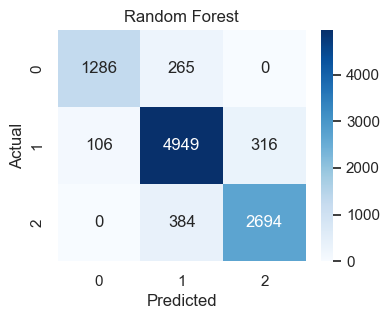

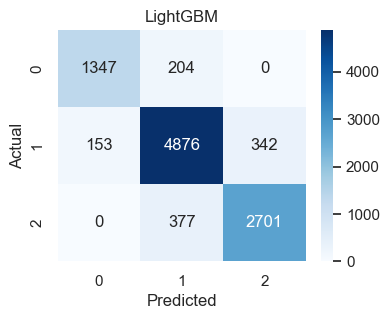

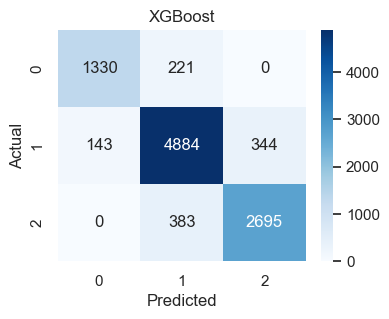

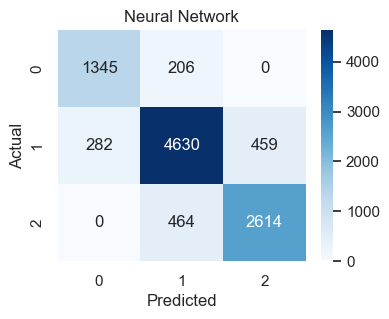

In [117]:
models = {
    "Random Forest": y_pred_rf,
    "LightGBM": y_pred_lgb,
    "XGBoost": y_pred_xgb,
    "Neural Network": y_pred_mlp
}

for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [118]:
# =========================
# LỌC DỮ LIỆU THEO THÁNG / NĂM
# =========================

# Chuyển cột Ngày sang datetime (nếu chưa)
df["Ngày"] = pd.to_datetime(df["Ngày"], errors="coerce")

# Nhập tháng / năm cần thống kê
thang_nhap = 6    # ví dụ: tháng 6
nam_nhap = 2022   # ví dụ: năm 2022

# Lọc dữ liệu
filtered_df = df[
    (df["Ngày"].dt.month == thang_nhap) &
    (df["Ngày"].dt.year == nam_nhap)
]

print("Số dòng sau khi lọc:", len(filtered_df))
display(filtered_df.head())


Số dòng sau khi lọc: 613


,Ngày,Quốc_gia,Loại_thảm_họa,Chỉ_số_nghiêm_trọng,Số_người_thương_vong,Thiệt_hại_kinh_tế_USD,Thời_gian_phản_ứng_giờ,Viện_trợ_USD,Hiệu_quả_ứng_phó,Số_ngày_phục_hồi,Vĩ_độ,Kinh_độ,Ngày_dt,Tháng,Mức_độ_thảm_họa
226,2022-06-19,Germany,Động đất,2.97,61,3604796.46,19.64,158892.65,78.53,25,-26.894,159.190,2022-06-19,6,0
273,2022-06-10,Chile,Lũ lụt,9.46,249,11832245.83,1.00,370427.91,95.06,91,44.463,83.574,2022-06-10,6,2
515,2022-06-09,Australia,Động đất,3.42,41,5267422.14,7.29,142524.38,92.88,34,-20.134,40.865,2022-06-09,6,1
582,2022-06-12,China,Động đất,4.11,86,3362250.51,1.65,173498.17,96.82,44,15.073,76.836,2022-06-12,6,1
602,2022-06-19,Japan,Động đất,5.09,130,9817063.18,7.02,287585.41,83.96,38,0.793,43.714,2022-06-19,6,1


--- THỐNG KÊ THẢM HỌA THÁNG 6/2022 ---
Mức độ Nhỏ: 105 vụ
Mức độ Lớn: 321 vụ
Mức độ Siêu thảm họa: 187 vụ
Tổng cộng: 613 vụ.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35276\1061298488.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


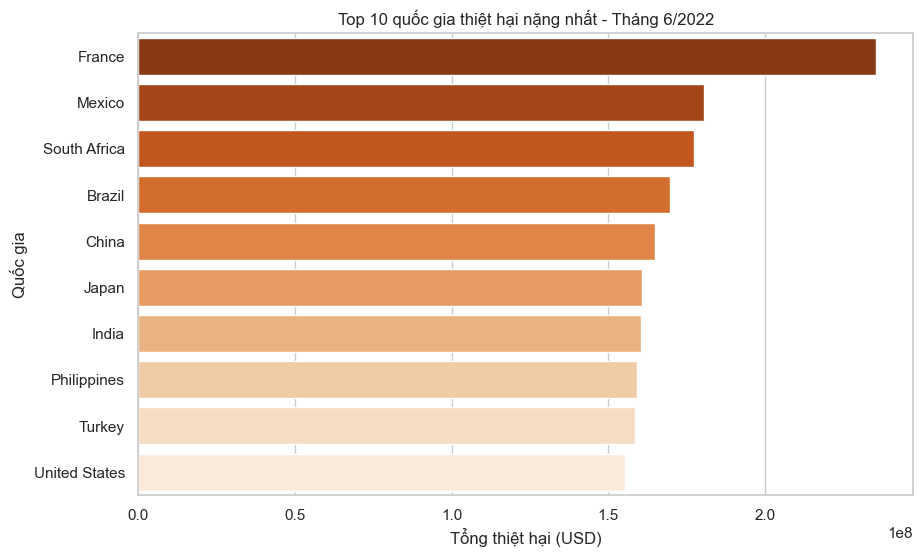

C:\Users\ASUS\AppData\Local\Temp\ipykernel_35276\1061298488.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


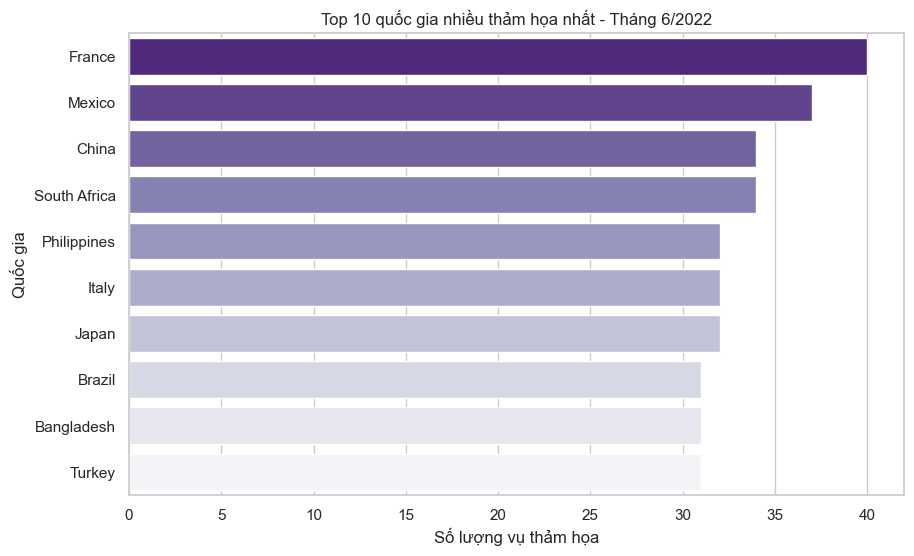

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 6. THỐNG KÊ SỐ LƯỢNG THẢM HỌA
# =========================

counts = filtered_df["Mức_độ_thảm_họa"].value_counts()
mapping = {0: "Nhỏ", 1: "Lớn", 2: "Siêu thảm họa"}

print(f"--- THỐNG KÊ THẢM HỌA THÁNG {thang_nhap}/{nam_nhap} ---")

if filtered_df.empty:
    print("Không có dữ liệu cho thời gian này.")
else:
    for level_code, name in mapping.items():
        so_luong = counts.get(level_code, 0)
        print(f"Mức độ {name}: {so_luong} vụ")

    print(f"Tổng cộng: {len(filtered_df)} vụ.")

    # =========================
    # VẼ BIỂU ĐỒ
    # =========================
    sns.set(style="whitegrid")

    # --- Biểu đồ 1: Top 10 quốc gia thiệt hại nặng nhất ---
    top_loss = (
        filtered_df
        .groupby("Quốc_gia")["Thiệt_hại_kinh_tế_USD"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_loss,
        x="Thiệt_hại_kinh_tế_USD",
        y="Quốc_gia",
        palette="Oranges_r"
    )
    plt.title(f"Top 10 quốc gia thiệt hại nặng nhất - Tháng {thang_nhap}/{nam_nhap}")
    plt.xlabel("Tổng thiệt hại (USD)")
    plt.ylabel("Quốc gia")
    plt.show()

    # --- Biểu đồ 2: Top 10 quốc gia nhiều thảm họa nhất ---
    top_count = (
        filtered_df["Quốc_gia"]
        .value_counts()
        .head(10)
        .reset_index()
    )
    top_count.columns = ["Quốc_gia", "Số_lượng_vụ"]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_count,
        x="Số_lượng_vụ",
        y="Quốc_gia",
        palette="Purples_r"
    )
    plt.title(f"Top 10 quốc gia nhiều thảm họa nhất - Tháng {thang_nhap}/{nam_nhap}")
    plt.xlabel("Số lượng vụ thảm họa")
    plt.ylabel("Quốc gia")
    plt.show()


In [120]:
# =========================
# FORM NHẬP DỮ LIỆU GIẢ ĐỊNH
# =========================

country_w = widgets.Dropdown(
    options=sorted(df["Quốc_gia"].dropna().unique()),
    description="Quốc gia:"
)

disaster_type_w = widgets.Dropdown(
    options=sorted(df["Loại_thảm_họa"].dropna().unique()),
    description="Thảm họa:"
)
month_w = widgets.IntSlider(
    value=6,
    min=1,
    max=12,
    step=1,
    description="Tháng:"
)

casualties_w = widgets.IntSlider(
    value=100,
    min=0,
    max=50000,
    step=10,
    description="Thương vong:"
)

economic_loss_w = widgets.FloatSlider(
    value=1_000_000,
    min=0,
    max=50_000_000_000,
    step=100_000,
    description="Thiệt hại USD:",
    readout_format=".0f"
)

response_time_w = widgets.FloatSlider(
    value=24,
    min=0,
    max=240,
    step=1,
    description="Phản ứng (giờ):"
)

aid_amount_w = widgets.FloatSlider(
    value=500_000,
    min=0,
    max=10_000_000_000,
    step=50_000,
    description="Viện trợ USD:",
    readout_format=".0f"
)

response_eff_w = widgets.FloatSlider(
    value=0.7,
    min=0,
    max=1,
    step=0.01,
    description="Hiệu quả:"
)

recovery_days_w = widgets.IntSlider(
    value=60,
    min=0,
    max=2000,
    step=5,
    description="Phục hồi (ngày):"
)

latitude_w = widgets.FloatText(
    description="Vĩ độ:",
    disabled=True
)

longitude_w = widgets.FloatText(
    description="Kinh độ:",
    disabled=True
)


In [121]:
def on_country_change(change):
    quoc_gia = change["new"]
    if quoc_gia in country_coord_dict:
        lat, lon = country_coord_dict[quoc_gia]
        latitude_w.value = float(lat)
        longitude_w.value = float(lon)

country_w.observe(on_country_change, names="value")
# Khóa không cho nhập tay (auto theo quốc gia)
latitude_w.disabled = True
longitude_w.disabled = True
model_w = widgets.Dropdown(
				options=["Random Forest", "LightGBM", "XGBoost", "Neural Network"],
				description="Model:"
)

In [122]:
# =========================
# CHỌN MODEL
# =========================
models_dict = {
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "Neural Network": mlp_model
}

model_w = widgets.Dropdown(
    options=list(models_dict.keys()),
    value="Random Forest",
    description="Model:"
)

# =========================
# NÚT + OUTPUT
# =========================
btn = widgets.Button(description=" Dự đoán mức độ thảm họa")
out = widgets.Output()

# =========================
# HÀM DỰ ĐOÁN
# =========================
def on_predict_clicked(b):
    with out:
        out.clear_output()

        input_df = pd.DataFrame([{
              "Quốc_gia": country_w.value,
														"Loại_thảm_họa": disaster_type_w.value,
														"Số_người_thương_vong": casualties_w.value,
														"Thiệt_hại_kinh_tế_USD": economic_loss_w.value,
														"Thời_gian_phản_ứng_giờ": response_time_w.value,
														"Viện_trợ_USD": aid_amount_w.value,
														"Hiệu_quả_ứng_phó": response_eff_w.value,
														"Số_ngày_phục_hồi": recovery_days_w.value,
														"Vĩ_độ": latitude_w.value,
														"Kinh_độ": longitude_w.value,
														"Tháng": month_w.value
        }])

        selected_model = models_dict[model_w.value]
        pred = selected_model.predict(input_df)[0]

        mapping = {
            0: " Nhỏ",
            1: "Lớn",
            2: " Siêu thảm họa"
        }

        print(f" Model sử dụng: {model_w.value}")
        print("MỨC ĐỘ DỰ ĐOÁN:", mapping[pred])

# =========================
# GÁN SỰ KIỆN + HIỂN THỊ
# =========================
btn.on_click(on_predict_clicked)

display(
    model_w,
    country_w,
    disaster_type_w,
    month_w,
    casualties_w,
    economic_loss_w,
    response_time_w,
    aid_amount_w,
    response_eff_w,
    recovery_days_w,
    latitude_w,
    longitude_w,
    btn,
    out
)


Dropdown(description='Model:', options=('Random Forest', 'LightGBM', 'XGBoost', 'Neural Network'), value='Rand…

Dropdown(description='Quốc gia:', options=('Australia', 'Bangladesh', 'Brazil', 'Canada', 'Chile', 'China', 'F…

Dropdown(description='Thảm họa:', options=('Bão lớn (Hurricane)', 'Cháy rừng', 'Hạn hán', 'Lũ lụt', 'Lốc xoáy'…

IntSlider(value=6, description='Tháng:', max=12, min=1)

IntSlider(value=100, description='Thương vong:', max=50000, step=10)

FloatSlider(value=1000000.0, description='Thiệt hại USD:', max=50000000000.0, readout_format='.0f', step=10000…

FloatSlider(value=24.0, description='Phản ứng (giờ):', max=240.0, step=1.0)

FloatSlider(value=500000.0, description='Viện trợ USD:', max=10000000000.0, readout_format='.0f', step=50000.0…

FloatSlider(value=0.7, description='Hiệu quả:', max=1.0, step=0.01)

IntSlider(value=60, description='Phục hồi (ngày):', max=2000, step=5)

FloatText(value=0.0, description='Vĩ độ:', disabled=True)

FloatText(value=0.0, description='Kinh độ:', disabled=True)

Button(description=' Dự đoán mức độ thảm họa', style=ButtonStyle())

Output()

In [ ]:
# ==============================================================================
# TÍNH NĂNG: DỰ BÁO THIÊN TAI THEO THÁNG & QUỐC GIA
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. Chuẩn bị dữ liệu
# ---------------------------------------------------------
# Đảm bảo cột Ngày đã được chuyển đổi
df['Ngày_dt'] = pd.to_datetime(df['Ngày'], dayfirst=True, errors='coerce')
df['Tháng'] = df['Ngày_dt'].dt.month

# Lấy danh sách quốc gia để đưa vào menu chọn
# Thêm tùy chọn "Tất cả" ở đầu danh sách
ds_quoc_gia = ['Tất cả'] + sorted(df['Quốc_gia'].dropna().unique().tolist())

# 2. Hàm xử lý dự báo
# ---------------------------------------------------------
def du_bao_thien_tai_nang_cap(thang, quoc_gia):
    """
    Dự báo dựa trên dữ liệu lịch sử của Tháng và Quốc gia được chọn
    """
    # Bước 1: Lọc dữ liệu
    df_loc = df.copy()
    
    # Lọc theo quốc gia (nếu không chọn 'Tất cả')
    if quoc_gia != 'Tất cả':
        df_loc = df_loc[df_loc['Quốc_gia'] == quoc_gia]
    
    # Lọc theo tháng
    df_loc = df_loc[df_loc['Tháng'] == thang]
    
    # Bước 2: Kiểm tra dữ liệu sau khi lọc
    so_luong_mau = len(df_loc)
    
    if so_luong_mau == 0:
        print(f" Không tìm thấy dữ liệu lịch sử nào cho:")
        print(f"   - Quốc gia: {quoc_gia}")
        print(f"   - Tháng: {thang}")
        print("=> Chưa đủ dữ liệu để dự báo.")
        return

    # Bước 3: Tính toán tần suất
    thong_ke = df_loc['Loại_thảm_họa'].value_counts()
    top_3 = thong_ke.head(3)
    
    # Bước 4: Hiển thị kết quả
    print(f"\n🔮 KẾT QUẢ DỰ BÁO CHO: {quoc_gia.upper()} - THÁNG {thang}")
    print(f"(Dựa trên phân tích {so_luong_mau} sự kiện trong quá khứ)")
    print("=" * 50)
    
    for tham_hoa, so_vu in top_3.items():
        ty_le = (so_vu / so_luong_mau) * 100
        print(f"{tham_hoa}")
        print(f"   - Xác suất xảy ra: {ty_le:.1f}%")
        print(f"   - Số vụ đã ghi nhận: {so_vu}")
        print("-" * 30)
        
    # Bước 5: Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    sns.barplot(x=thong_ke.values[:5], y=thong_ke.index[:5], palette="Reds_r")
    plt.title(f"Top Thiên Tai Thường Gặp - Tháng {thang} ({quoc_gia})")
    plt.xlabel("Số vụ ghi nhận")
    plt.show()

# 3. Tạo giao diện điều khiển
# ---------------------------------------------------------
lbl_header = widgets.HTML("<h3> CÔNG CỤ DỰ BÁO THIÊN TAI TƯƠNG LAI</h3>")

# Widget chọn Quốc gia
w_quoc_gia = widgets.Dropdown(
    options=ds_quoc_gia,
    value='Tất cả',
    description='Quốc gia:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Widget chọn Tháng
w_thang = widgets.IntSlider(
    value=6,
    min=1,
    max=12,
    step=1,
    description='Tháng dự báo:',
    style={'description_width': 'initial'}
)

# Nút Xem dự báo
btn_run = widgets.Button(
    description='Xem Dự Báo',
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    icon='check'
)

# Vùng hiển thị kết quả
output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        clear_output() # Xóa kết quả cũ
        du_bao_thien_tai_nang_cap(w_thang.value, w_quoc_gia.value)

btn_run.on_click(on_button_click)

# Hiển thị tất cả ra màn hình
display(lbl_header, w_quoc_gia, w_thang, btn_run, output_area)